## Описание файлов
- transactions.csv - исторические транзакции банковских клиентов
- gender.csv - информация по полу для части клиентов (null - для тестовых)
- tr_mcc_codes.csv - mcc-коды транзакций
- tr_types.csv - типы транзакций

## Описание полей
### transactions.csv
- customer_id - идентификатор клиента
- tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)
- mcc_code - mcc-код транзакции
- tr_type - тип транзакции
- amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту, "-" — списание средств
- term_id - идентификатор терминала

### gender.csv
- customer_id - идентификатор клиента
- gender - пол клиента (пустые значения - тестовые клиенты)

### tr_mcc_codes.csv
- mcc_code - mcc-код транзакции
- mcc_description - описание mcc-кода транзакции

### tr_types.csv
- tr_type - тип транзакции
- tr_description - описание типа транзакции

## Задачи:
- Разработать модель бинарной классификации для определения пола клиента. Никаких ограничений к модели - может быть что угодно от KNN до трансформеров. Главное, чтобы ROC AUC на отложенном тесте получился выше 77.5%.
- Интерпретировать результаты модели: важность входящих в нее переменных, демонстрация на нескольких примерах, почему получился соответствующий прогноз. Последнее позволит понять, какой пол к какому из таргетов (0/1) принадлежит. Опять же, полная свобода выбора подходов! Полезные ключевые слова: gain, permutation importance, SHAP. 
- Конвертировать результаты в отчет без кода (идеально - напрямую в [html](https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html))

#### P.S. Не забываем про [PEP8](https://www.python.org/dev/peps/pep-0008/)!

In [148]:
import numpy as np
import pandas as pd

# NLP
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian')) # множество русских стоп-слов
from pymorphy2 import MorphAnalyzer # лемматизатор для русских слов 
import fasttext # векторайзер для текста 
import fasttext.util

# методы понижения размерности
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# графики 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # отображение облака слов

# отбор признаков
import shap

# модель
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score # метрика 
from sklearn.model_selection import KFold # кросс-валидация 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import datetime

# пропущеные значения
def missing_features(data):
    missing_data = data.isna().sum()
    for i in range(len(missing_data)):
        if missing_data[i] > 0:
            print('{} - {} шт. ({} %)'.format(missing_data.index[i],missing_data[i], round(missing_data[i]/len(data) * 100, 2)))

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [17]:
tr_mcc_codes = pd.read_csv("data/tr_mcc_codes.csv", sep=";", index_col="mcc_code")
tr_types = pd.read_csv("data/tr_types.csv", sep=";", index_col="tr_type")
transactions = pd.read_csv("data/transactions.csv", index_col="customer_id")
gender = pd.read_csv("data/gender.csv", index_col="customer_id")

In [18]:
transactions

,tr_datetime,mcc_code,tr_type,amount,term_id
customer_id,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,NaN
39026145,1 10:19:29,6011,7010,56147.89,NaN
39026145,1 10:20:56,4829,2330,-56147.89,NaN
39026145,1 10:39:54,5499,1010,-1392.47,NaN
39026145,2 15:33:42,5499,1010,-920.83,NaN
...,...,...,...,...,...
61870738,453 16:03:02,5499,1010,-5176.84,10217113
61870738,454 10:54:60,5411,1010,-1652.77,022915
61870738,454 14:23:59,5499,1010,-4687.23,10217113


In [19]:
tr_types

,tr_description
tr_type,
3200,Плата за предоставление услуг посредством моби...
3210,Плата за предоставление отчета по счету карты ...
3800,Плата за обслуживание банковской карты (за пер...
4000,Плата за получение наличных в Сбербанке
4001,Плата за получение наличных в Сбербанке (в дру...
...,...
2990,Списание по требованию
2992,Списание средств для погашения задолженности п...
3001,Комиссия за обслуживание ссудного счета


In [20]:
gender

,gender
customer_id,
6740969,1.0
36599781,0.0
91453656,1.0
17431962,1.0
72568668,1.0
...,...
37415294,NaN
53882112,NaN
70027904,NaN


In [21]:
tr_mcc_codes

,mcc_description
mcc_code,
742,Ветеринарные услуги
1711,"Генеральные подрядчики по вентиляции, теплосна..."
1731,Подрядчики по электричеству
1799,"Подрядчики, специализированная торговля — нигд..."
2741,Разнообразные издательства/печатное дело
...,...
9211,"Судовые выплаты, включая алименты и детскую по..."
9222,Штрафы
9311,Налоговые платежи


### NLP

In [22]:
# предобработка текста
stop_words.update({'тот', 'весь', 'ранее', 'нигде'}) # добавление стоп слов
str_punc = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+—/"
morph = MorphAnalyzer()
def data_preprocessing(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in str_punc])    
    text = [word for word in text.split() if word not in stop_words]
    tokens = []
    for token in text:
        token = token.strip()
        token = morph.normal_forms(token)[0]
        if len(token) > 2:
            tokens.append(token)
    tokens = ' '.join(tokens)
    return tokens

In [23]:
# очищаем данные, применяем лемматизацию 
tr_types['cleaned_tr_description'] = tr_types['tr_description'].apply(data_preprocessing)
tr_mcc_codes['cleaned_mcc_description'] = tr_mcc_codes['mcc_description'].apply(data_preprocessing)

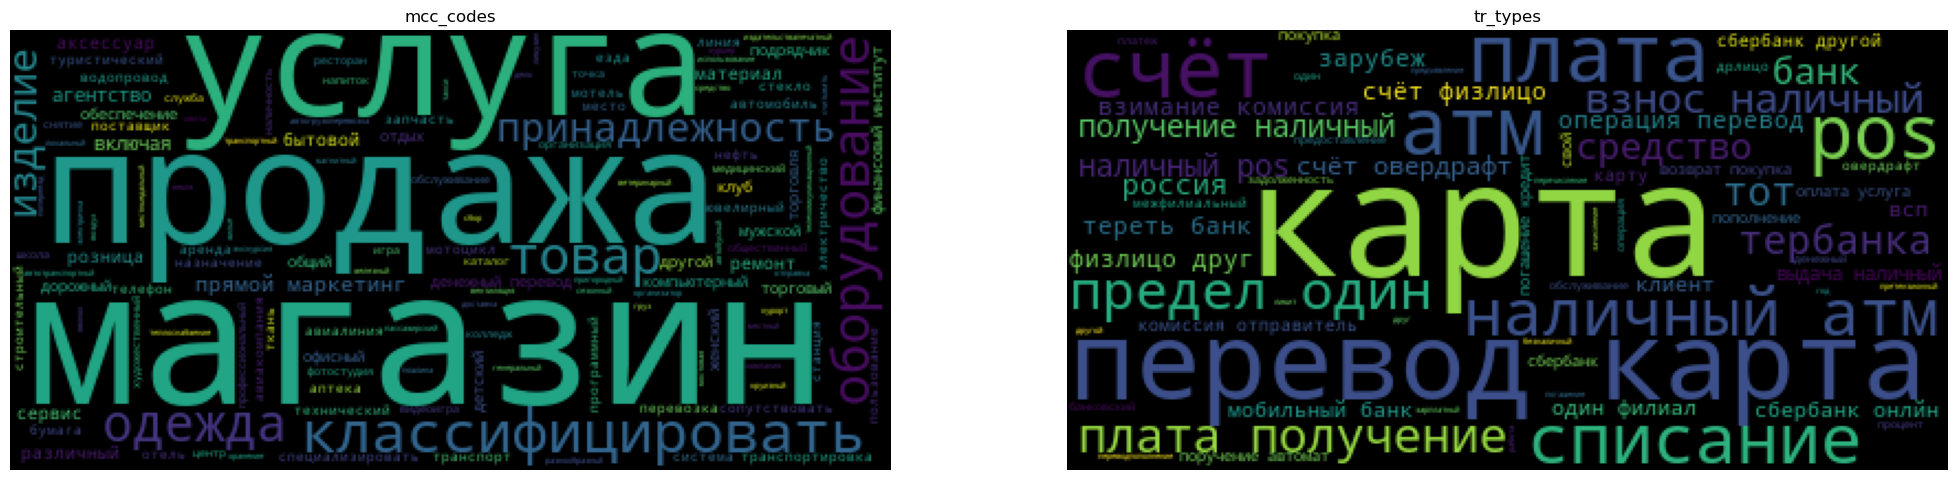

In [24]:
# облако слов
text_mcc = ' '.join(tr_mcc_codes['cleaned_mcc_description']) 
cloud_mcc = WordCloud().generate(text_mcc) # Генерируем облако слов и сохраняем в переменной cloud

text_tr = ' '.join(tr_types['cleaned_tr_description']) 
cloud_tr = WordCloud().generate(text_tr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 22))

ax1.axis('off')
ax2.axis('off')
ax1.imshow(cloud_mcc)
ax2.imshow(cloud_tr)
ax1.set_title('mcc_codes')
ax2.set_title('tr_types');

In [25]:
ft = fasttext.load_model('cc.ru.300') # модель для векторизации русских слов c размером вектора 300 по умолчанию
dimension_vector = ft.get_dimension() # размера вектора
dimension_vector

300

In [26]:
# векторизируем текстовые данные
tr_mcc_codes['vector_mcc_description'] = [ft.get_word_vector(i) for i in tr_mcc_codes['cleaned_mcc_description']]
tr_types['vector_tr_description'] = [ft.get_word_vector(i) for i in tr_types['cleaned_tr_description']]

In [27]:
# создание датафреймов с векторизацией описаний
columns_mcc = ['vector_mcc_description{}'.format(i) for i in range(dimension_vector)]
df_vector_mcc_description = pd.DataFrame(list(tr_mcc_codes['vector_mcc_description']), tr_mcc_codes['vector_mcc_description'].index, columns_mcc)

columns_tr = ['vector_tr_description{}'.format(i) for i in range(dimension_vector)]
df_vector_tr_description = pd.DataFrame(list(tr_types['vector_tr_description']), tr_types['vector_tr_description'].index, columns_tr)

In [14]:
# # понижение размерности векторов описаний mcc_codes
# pca = PCA(n_components= 2, whiten=True, svd_solver= 'full', random_state= 42)
# tsne = TSNE(n_components= 2, perplexity= 1, learning_rate= 1, random_state= 42)
# svd = TruncatedSVD(n_components= 2, n_iter= 20, random_state= 42)

# X_pca_mcc = pca.fit_transform(df_vector_mcc_description)
# X_tsne_mcc = tsne.fit_transform(df_vector_mcc_description)
# X_svd_mcc = svd.fit_transform(df_vector_mcc_description)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# ax1.scatter(X_pca_mcc[:, 0], X_pca_mcc[:, 1])
# ax2.scatter(X_tsne_mcc[:, 0], X_tsne_mcc[:, 1])
# ax3.scatter(X_svd_mcc[:, 0], X_svd_mcc[:, 1])

# ax1.set_title('PCA')
# ax2.set_title('TSNE')
# ax3.set_title('SVD');

In [15]:
# # понижение размерности векторов описаний tr_types
# pca = PCA(n_components= 2, whiten= True, svd_solver= 'full', random_state= 42)
# tsne = TSNE(n_components= 2, perplexity= 6, learning_rate= 100, random_state= 42)
# svd = TruncatedSVD(n_components= 2, n_iter= 20, random_state= 42)

# X_pca_tr = pca.fit_transform(df_vector_tr_description)
# X_tsne_tr = tsne.fit_transform(df_vector_tr_description)
# X_svd_tr = svd.fit_transform(df_vector_tr_description)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# ax1.scatter(X_pca_tr[:, 0], X_pca_tr[:, 1])
# ax2.scatter(X_tsne_tr[:, 0], X_tsne_tr[:, 1])
# ax3.scatter(X_svd_tr[:, 0], X_svd_tr[:, 1])

# ax1.set_title('PCA')
# ax2.set_title('TSNE')
# ax3.set_title('SVD');

In [37]:
# # преобразованные данные формируем в датафрейм
# col_tr = ['TSNE_1_tr', 'TSNE_2_tr'] 
# df_tsne_df_vector_tr_description = pd.DataFrame(X_tsne_tr, columns = col_tr)
# col_mcc = ['TSNE_1_mcc', 'TSNE_2_mcc'] 
# df_tsne_df_vector_mcc_description = pd.DataFrame(X_tsne_mcc, columns = col_mcc)

In [38]:
# df_tsne_df_vector_tr_description.index = tr_types.index
# df_tsne_df_vector_mcc_description.index = tr_mcc_codes.index

In [39]:
# # добавляем преобразованные переменные в датафрейм
# tr_mcc_codes = pd.concat([tr_mcc_codes, df_tsne_df_vector_mcc_description], axis=1)
# tr_types = pd.concat([tr_types, df_tsne_df_vector_tr_description], axis=1)

In [40]:
# # удаляем исходные текстовые данные 
# tr_mcc_codes = tr_mcc_codes.drop(['mcc_description', 'vector_mcc_description'], axis= 1)
# tr_types = tr_types.drop(['tr_description', 'vector_tr_description'], axis= 1)

### Data analysis and feature engineering

In [27]:
# объединяем данные из разных таблиц в одну 
# df = transactions
# df = df.join(gender)
# df = pd.merge(df, df_vector_mcc_description, left_on= "tr_type", right_index= True)
# df = pd.merge(df, df_vector_tr_description, left_on= "mcc_code", right_index= True)
# df = df.drop(['mcc_code', 'tr_type'], axis= 1)
# df

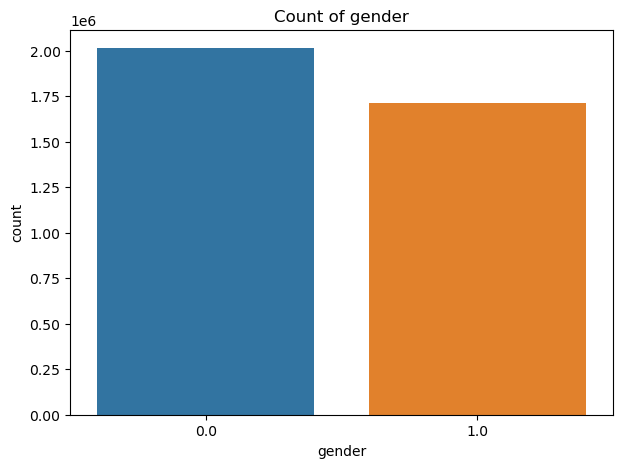

In [146]:
fig, ax = plt.subplots(figsize = (7, 5))
ax = sns.countplot(x= 'gender',data= df).set(title= 'Count of gender')

In [147]:
df['purchase'] = [1 if i < 0 else 0 for i in df['amount']] # маркер покупки
df['day'] = pd.DataFrame(df["tr_datetime"].str.split(' ', expand = True)[0]).astype("int64").fillna(0) # день транзакции
df['time'] = pd.DataFrame(df["tr_datetime"].str.split(' ', expand = True)[1].str.split(':', expand = True)[0]).astype("int64") # час транзакции

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


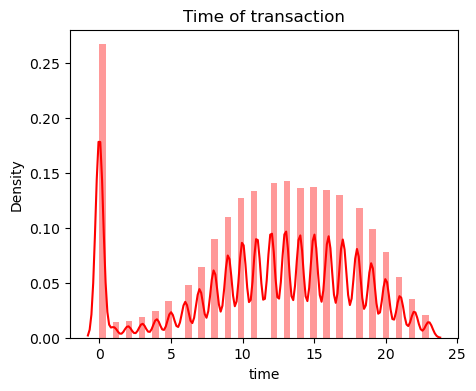

In [148]:
plt.subplots(figsize = (5, 4))
sns.distplot(df['time'], color = 'red').set(title='Time of transaction');
plt.show()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


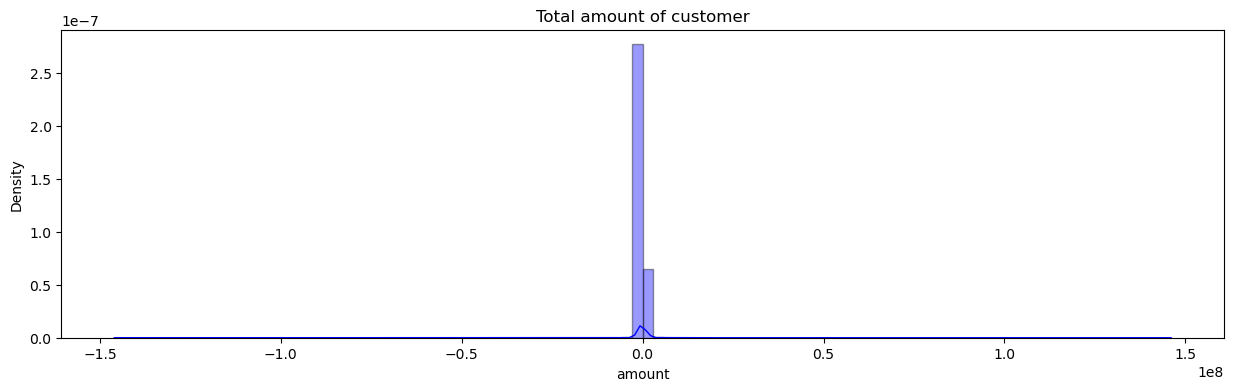

In [149]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df['amount'], hist=True, kde=True, 
             bins= 100, color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}).set(title='Total amount of customer');
plt.show()

In [150]:
df['total'] = df.groupby(['customer_id'])["amount"].sum().fillna(0) # общая сумма транзакций каждого клиента

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


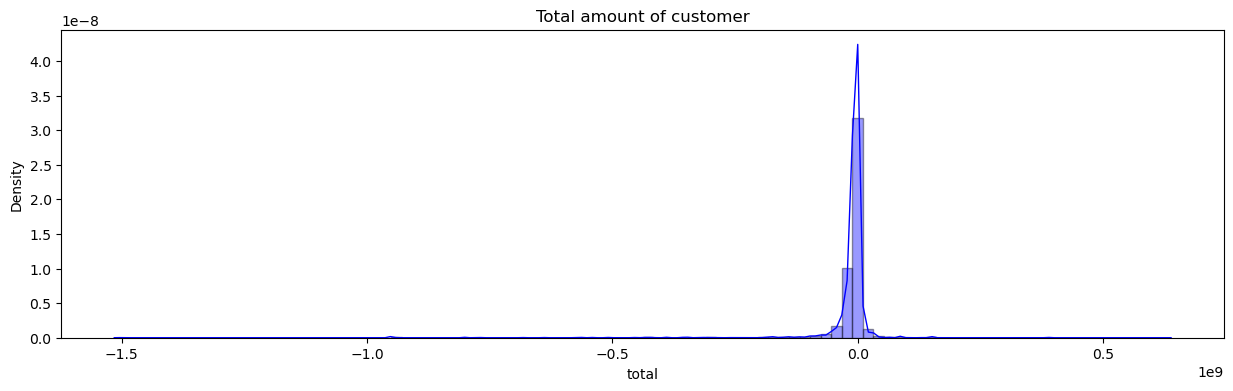

Максимальное значение: 628984684.12
Минимальное значение: -1505728530.04


In [151]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df['total'], hist=True, kde=True, 
             bins= 100, color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}).set(title='Total amount of customer');
plt.show()
print('Максимальное значение:', df['total'].max())
print('Минимальное значение:', df['total'].min())

In [152]:
df['total_spent'] = df.loc[df['purchase'] == 1].groupby(['customer_id'])["amount"].sum().fillna(0) # сумма трат

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


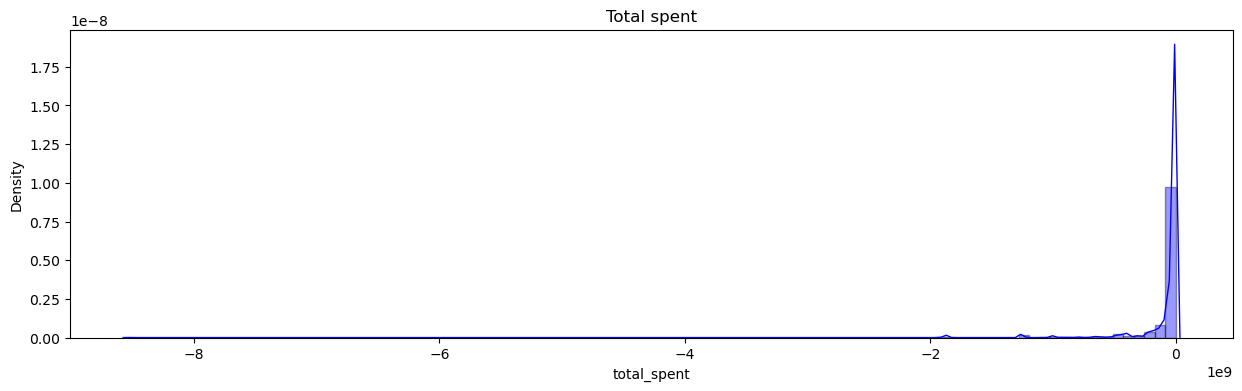

Максимальное значение: -224.59
Минимальное значение: -8541879253.05


In [153]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df['total_spent'], hist=True, kde=True, 
             bins= 100, color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}).set(title='Total spent');
plt.show()

print('Максимальное значение:', df['total_spent'].max())
print('Минимальное значение:', df['total_spent'].min())

In [154]:
df['total_earned'] = df.loc[df['purchase'] == 0].groupby(['customer_id'])["amount"].sum().fillna(0) # сумма заработка

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


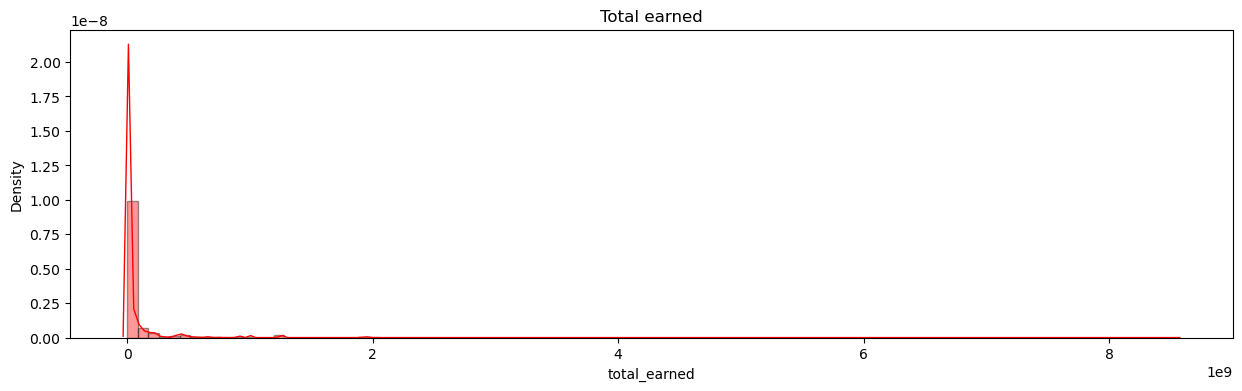

Максимальное значение: 8542244401.49
Минимальное значение: 0.22


In [155]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df['total_earned'], hist=True, kde=True, 
             bins= 100, color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}).set(title='Total earned');
plt.show()

print('Максимальное значение:', df['total_earned'].max())
print('Минимальное значение:', df['total_earned'].min())


In [156]:
df['transactions_per_time'] = df.groupby(df.index)["time"].transform("mean").fillna(0) # время транзакций

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


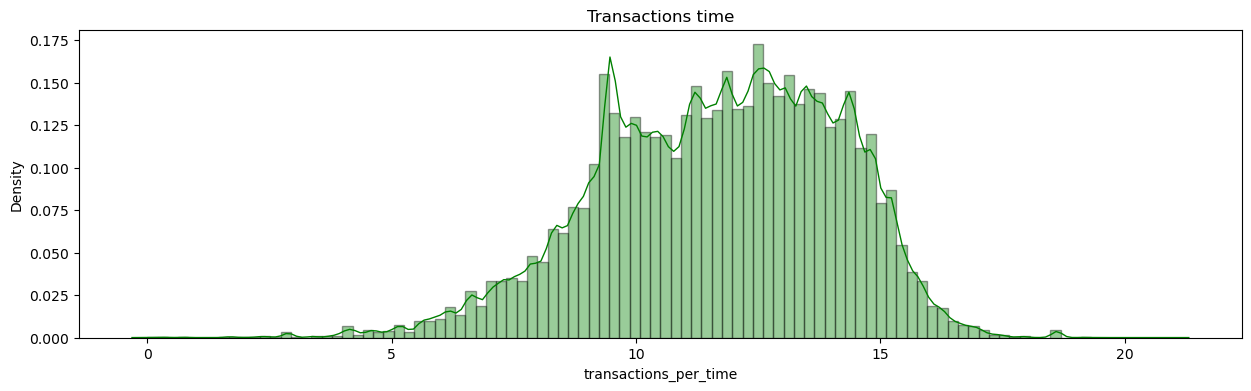

In [157]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df['transactions_per_time'], hist=True, kde=True, 
             bins= 100, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}).set(title='Transactions time');
plt.show()

In [158]:
df['transactions_per_day'] = df.groupby([df.index])["day"].transform("mean").fillna(0) # количество транзакций в день

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


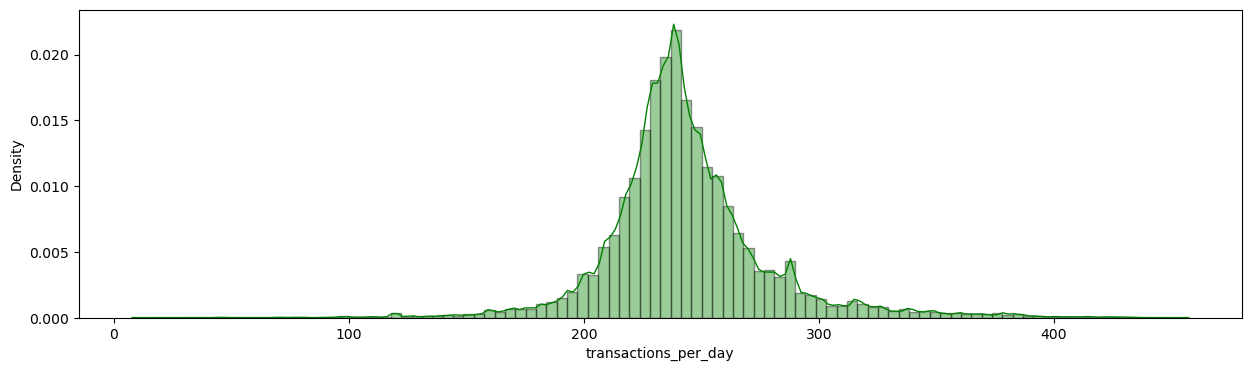

In [159]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df['transactions_per_day'], hist=True, kde=True, 
             bins= 100, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}).set(title='');
plt.show()

In [160]:
df['sum_per_day'] = df.groupby([df.index, 'day'])['amount'].transform('sum').fillna(0) # сумма транзакций в день каждого пользователя

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


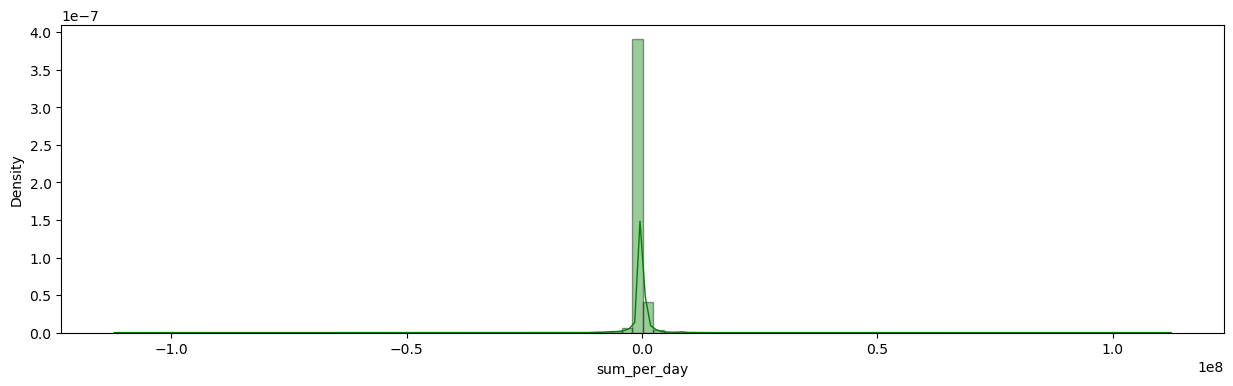

In [161]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df['sum_per_day'], hist=True, kde=True, 
             bins= 100, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}).set(title='');
plt.show()

In [162]:
df["avg_amount_per_day"] = df.groupby([df.index, 'day'])["amount"].transform('mean').fillna(0) # среднее транзакций в день каждого клиента

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


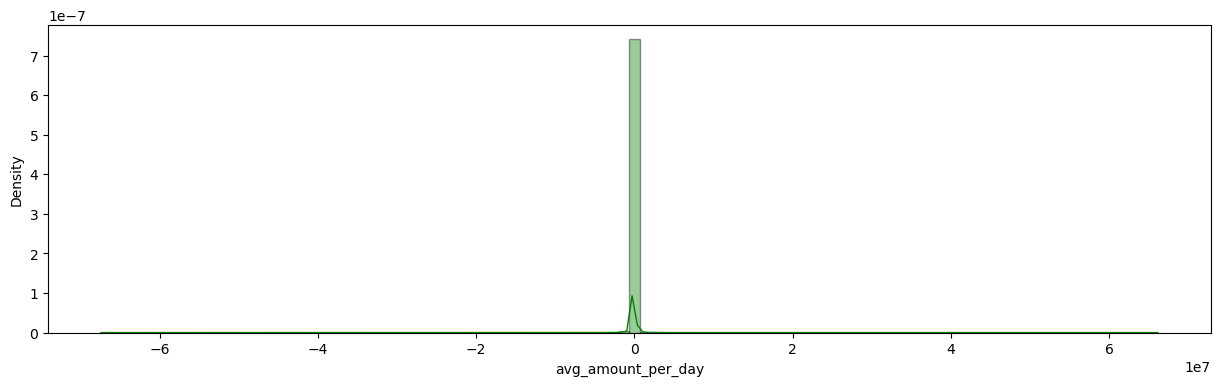

In [163]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df['avg_amount_per_day'], hist=True, kde=True, 
             bins= 100, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}).set(title='');
plt.show()

In [164]:
df

,tr_datetime,amount,term_id,gender,cleaned_tr_description,TSNE_1_tr,TSNE_2_tr,cleaned_mcc_description,TSNE_1_mcc,TSNE_2_mcc,purchase,day,time,total,total_spent,total_earned,transactions_per_time,transactions_per_day,sum_per_day,avg_amount_per_day
customer_id,,,,,,,,,,,,,,,,,,,,
6815,10 10:52:00,-2245.92,NaN,NaN,оплата услуга банкомат,14.007637,37.893898,звонок использование телефон считывать магнитн...,47.359173,6.449200,1,10,10,-1249454.87,-3956007.97,2706553.10,12.699115,236.154867,-4491.84,-2245.920000
6815,10 14:44:36,-2245.92,NaN,NaN,оплата услуга банкомат,14.007637,37.893898,звонок использование телефон считывать магнитн...,47.359173,6.449200,1,10,14,-1249454.87,-3956007.97,2706553.10,12.699115,236.154867,-4491.84,-2245.920000
6815,17 12:33:31,-2245.92,NaN,NaN,оплата услуга банкомат,14.007637,37.893898,звонок использование телефон считывать магнитн...,47.359173,6.449200,1,17,12,-1249454.87,-3956007.97,2706553.10,12.699115,236.154867,-47164.24,-23582.120000
6815,23 11:45:37,-2245.92,NaN,NaN,оплата услуга банкомат,14.007637,37.893898,звонок использование телефон считывать магнитн...,47.359173,6.449200,1,23,11,-1249454.87,-3956007.97,2706553.10,12.699115,236.154867,-2245.92,-2245.920000
6815,34 20:24:21,-2245.92,NaN,NaN,оплата услуга банкомат,14.007637,37.893898,звонок использование телефон считывать магнитн...,47.359173,6.449200,1,34,20,-1249454.87,-3956007.97,2706553.10,12.699115,236.154867,-2245.92,-2245.920000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69407297,425 00:00:00,-22459.16,22697001,0.0,покупка тот россия,-32.287674,7.378399,судовой выплата включая алименты детский подде...,14.391477,-28.679491,1,425,0,-22184826.80,-38532791.35,16347964.55,9.064151,218.937736,-22459.16,-22459.160000
69407297,431 00:00:00,-22459.16,24436001,0.0,покупка тот россия,-32.287674,7.378399,судовой выплата включая алименты детский подде...,14.391477,-28.679491,1,431,0,-22184826.80,-38532791.35,16347964.55,9.064151,218.937736,-22459.16,-22459.160000
69407297,445 00:00:00,-17967.33,22697001,0.0,покупка тот россия,-32.287674,7.378399,судовой выплата включая алименты детский подде...,14.391477,-28.679491,1,445,0,-22184826.80,-38532791.35,16347964.55,9.064151,218.937736,588429.93,294214.965000


In [165]:
df = pd.DataFrame(pd.get_dummies(data = df, columns = ['cleaned_tr_description', 'cleaned_mcc_description']))

In [166]:
df_customers = df.groupby(['customer_id']).mean()

In [167]:
df_customers = df_customers[df_customers['gender'].notna()]
Y = df_customers['gender']

In [169]:
df_customers

,amount,gender,TSNE_1_tr,TSNE_2_tr,TSNE_1_mcc,TSNE_2_mcc,purchase,day,time,total,...,cleaned_mcc_description_фотостудия фотолаборатория,cleaned_mcc_description_химикалии смежный вещество классифицировать,cleaned_mcc_description_химчистка,cleaned_mcc_description_ценный бумага брокерыдилер,cleaned_mcc_description_центр здоровье,cleaned_mcc_description_цифровой товар игра,cleaned_mcc_description_школа бизнес секретарь,cleaned_mcc_description_штраф,cleaned_mcc_description_штучный товар галантерея другой текстильный товар,cleaned_mcc_description_электрический часть оборудование
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,-2691.438419,1.0,-7.601777,3.450278,18.346621,14.938688,0.709402,238.568376,12.837607,-629796.59,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
27914,-26820.061441,1.0,-3.379012,10.675229,32.903236,15.039827,0.684685,243.558559,11.486486,-2977026.82,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
28753,-90293.479116,0.0,-14.196839,6.392141,11.796496,7.499558,0.829932,194.602041,6.503401,-26546282.86,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
31385,-5972.612548,0.0,-13.636841,15.301723,18.522646,19.806366,0.936986,139.290411,14.550685,-2180003.58,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
38084,-2069.954916,0.0,-10.382638,13.897612,15.832048,9.894098,0.880252,247.638655,12.093487,-1970597.08,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,-28573.389826,0.0,-19.309919,1.932991,8.434982,21.429300,0.906977,249.540698,11.226744,-4914623.05,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
99967537,-142010.982308,1.0,-9.218702,12.428092,30.502014,20.469959,1.000000,368.000000,11.923077,-1846142.77,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
99988578,-13504.464201,1.0,-9.763192,10.470252,12.473244,12.324994,0.870460,262.914044,14.894673,-11154687.43,...,0.0,0.0,0.0,0.0,0.0,0.003632,0.0,0.0,0.0,0.0


In [170]:
df_customers = df_customers.drop(['gender'], axis= 1)

In [171]:
df_customers

,amount,TSNE_1_tr,TSNE_2_tr,TSNE_1_mcc,TSNE_2_mcc,purchase,day,time,total,total_spent,...,cleaned_mcc_description_фотостудия фотолаборатория,cleaned_mcc_description_химикалии смежный вещество классифицировать,cleaned_mcc_description_химчистка,cleaned_mcc_description_ценный бумага брокерыдилер,cleaned_mcc_description_центр здоровье,cleaned_mcc_description_цифровой товар игра,cleaned_mcc_description_школа бизнес секретарь,cleaned_mcc_description_штраф,cleaned_mcc_description_штучный товар галантерея другой текстильный товар,cleaned_mcc_description_электрический часть оборудование
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,-2691.438419,-7.601777,3.450278,18.346621,14.938688,0.709402,238.568376,12.837607,-629796.59,-6448719.64,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
27914,-26820.061441,-3.379012,10.675229,32.903236,15.039827,0.684685,243.558559,11.486486,-2977026.82,-3386906.52,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
28753,-90293.479116,-14.196839,6.392141,11.796496,7.499558,0.829932,194.602041,6.503401,-26546282.86,-72253691.83,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
31385,-5972.612548,-13.636841,15.301723,18.522646,19.806366,0.936986,139.290411,14.550685,-2180003.58,-3431338.03,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
38084,-2069.954916,-10.382638,13.897612,15.832048,9.894098,0.880252,247.638655,12.093487,-1970597.08,-28333044.22,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,-28573.389826,-19.309919,1.932991,8.434982,21.429300,0.906977,249.540698,11.226744,-4914623.05,-6812421.89,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
99967537,-142010.982308,-9.218702,12.428092,30.502014,20.469959,1.000000,368.000000,11.923077,-1846142.77,-1846142.77,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
99988578,-13504.464201,-9.763192,10.470252,12.473244,12.324994,0.870460,262.914044,14.894673,-11154687.43,-18869408.19,...,0.0,0.0,0.0,0.0,0.0,0.003632,0.0,0.0,0.0,0.0


In [339]:
# формируем датасет для обучения
X = df_customers
# X = X.drop(['tr_datetime', 'term_id', 'cleaned_tr_description', 'cleaned_mcc_description'], axis= 1)
X = X.drop(['tr_datetime', 'cleaned_tr_description', 'cleaned_mcc_description'], axis= 1)
# разъединяем данные на train и test
X_test = X[X['gender'].isna()]
X = X[X['gender'].notna()]
Y = X['gender']
X, X_test = X.drop(['gender'], axis= 1), X_test.drop(['gender'], axis= 1)

### Преобразования переменных

In [8]:
gender

,gender
customer_id,
6740969,1.0
36599781,0.0
91453656,1.0
17431962,1.0
72568668,1.0
...,...
37415294,NaN
53882112,NaN
70027904,NaN


In [151]:
import datetime

transactions['day'] = transactions['day'].apply(lambda x: datetime.date(2020, 1, 1) + datetime.timedelta(days= x))


TypeError: unsupported type for timedelta days component: datetime.date

In [145]:
transactions

,tr_datetime,mcc_code,tr_type,amount,term_id,gain,day,time
customer_id,,,,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,NaN,0,2020-01-01,10:23:26
39026145,1 10:19:29,6011,7010,56147.89,NaN,1,2020-01-02,10:19:29
39026145,1 10:20:56,4829,2330,-56147.89,NaN,0,2020-01-02,10:20:56
39026145,1 10:39:54,5499,1010,-1392.47,NaN,0,2020-01-02,10:39:54
39026145,2 15:33:42,5499,1010,-920.83,NaN,0,2020-01-03,15:33:42
...,...,...,...,...,...,...,...,...
61870738,453 16:03:02,5499,1010,-5176.84,10217113,0,2021-03-29,16:03:02
61870738,454 10:54:60,5411,1010,-1652.77,022915,0,2021-03-30,10:54:60
61870738,454 14:23:59,5499,1010,-4687.23,10217113,0,2021-03-30,14:23:59


In [81]:
# маркер транзакций: 0 - покупка, 1 - пополнение
transactions['gain'] = transactions['amount'].apply(lambda x: 0 if x < 0 else 1)

# день покупки
transactions['day'] = pd.DataFrame(transactions["tr_datetime"].str.split(' ', expand = True)[0].astype('int'))

# час покупки
transactions['time'] = pd.DataFrame(transactions["tr_datetime"].str.split(' ', expand = True)[1])

In [ ]:
# # amount клиента
# amount = transactions.groupby(['customer_id'])['amount'].agg(['mean', 'max', 'min', 'sum', 'std', 'count'])
# amount.columns = ['mean_amount', 'max_amount', 'min_amount', 'sum_amount', 'std_amount', 'count_amount']
# gender = gender.merge(amount, left_on= 'customer_id', right_index=True, how = 'left')

# amount клиента
amount = transactions.groupby(['customer_id'])['amount'].agg(['mean', 'max', 'min', 'sum', 'std', 'count'])
amount.columns = ['mean_amount', 'max_amount', 'min_amount', 'sum_amount', 'std_amount', 'count_amount']
transactions = transactions.merge(amount, left_on= 'customer_id', right_index=True, how = 'left')

In [ ]:
# # пополнения клиента
# gain = transactions[transactions['gain'] == 1].groupby(['customer_id'])['amount'].agg(['mean', 'max', 'min', 'sum', 'std', 'count'])
# gain.columns = ['mean_gain', 'max_gain', 'min_gain', 'sum_gain', 'std_gain', 'count_gain']
# gender = gender.merge(gain, left_on= 'customer_id', right_index=True, how = 'left')

# пополнения клиента
gain = transactions[transactions['gain'] == 1].groupby(['customer_id'])['amount'].agg(['mean', 'max', 'min', 'sum', 'std', 'count'])
gain.columns = ['mean_gain', 'max_gain', 'min_gain', 'sum_gain', 'std_gain', 'count_gain']
transactions = transactions.merge(gain, left_on= 'customer_id', right_index=True, how = 'left')

In [ ]:
# # покупки клиента
# purchase = transactions[transactions['gain'] == 0].groupby(['customer_id'])['amount'].agg(['mean', 'max', 'min', 'sum', 'std', 'count'])
# purchase.columns = ['mean_purchase', 'max_purchase', 'min_purchase', 'sum_purchase', 'std_purchase', 'count_purchase']
# gender = gender.merge(purchase, left_on= 'customer_id', right_index=True, how = 'left')

# покупки клиента
purchase = transactions[transactions['gain'] == 0].groupby(['customer_id'])['amount'].agg(['mean', 'max', 'min', 'sum', 'std', 'count'])
purchase.columns = ['mean_purchase', 'max_purchase', 'min_purchase', 'sum_purchase', 'std_purchase', 'count_purchase']
transactions = transactions.merge(purchase, left_on= 'customer_id', right_index=True, how = 'left')

In [27]:
# # присоединение NLP преобразований описаний
# transactions = pd.merge(transactions, tr_types, left_on= "tr_type", right_index= True)
# transactions = pd.merge(transactions, tr_mcc_codes, left_on= "mcc_code", right_index= True)

### Агрегация

In [ ]:
# # amount клиента в день 

# # sum
# transactions['sum_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('sum').fillna(0)
# gender['sum_amount_per_day_customers'] = transactions.groupby('customer_id')['sum_amount_per_day'].mean()

# # min
# transactions['min_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('min').fillna(0)
# gender['min_amount_per_day_customers'] = transactions.groupby('customer_id')['min_amount_per_day'].mean()

# # max
# transactions['max_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('max').fillna(0)
# gender['max_amount_per_day_customers'] = transactions.groupby('customer_id')['max_amount_per_day'].mean()

# # mean
# transactions['mean_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('mean').fillna(0)
# gender['mean_amount_per_day_customers'] = transactions.groupby('customer_id')['mean_amount_per_day'].mean()

# # count
# transactions['count_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('count').fillna(0)
# gender['count_amount_per_day_customers'] = transactions.groupby('customer_id')['count_amount_per_day'].mean()


# amount клиента в день 

# sum
transactions['sum_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('sum').fillna(0)

# min
transactions['min_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('min').fillna(0)

# max
transactions['max_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('max').fillna(0)

# mean
transactions['mean_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('mean').fillna(0)

# count
transactions['count_amount_per_day'] = transactions.groupby(['customer_id', 'day'])['amount'].transform('count').fillna(0)

In [ ]:
# # amount клиента по часам  

# # sum
# transactions['sum_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('sum').fillna(0)
# gender['sum_amount_per_time_customers'] = transactions.groupby('customer_id')['sum_amount_per_time'].mean()

# # min
# transactions['min_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('min').fillna(0)
# gender['min_amount_per_time_customers'] = transactions.groupby('customer_id')['min_amount_per_time'].mean()

# # max
# transactions['max_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('max').fillna(0)
# gender['max_amount_per_time_customers'] = transactions.groupby('customer_id')['max_amount_per_time'].mean()

# # mean
# transactions['mean_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('mean').fillna(0)
# gender['mean_amount_per_time_customers'] = transactions.groupby('customer_id')['mean_amount_per_time'].mean()

# # count
# transactions['count_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('count').fillna(0)
# gender['count_amount_per_time_customers'] = transactions.groupby('customer_id')['count_amount_per_time'].mean()

# amount клиента по часам  

# sum
transactions['sum_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('sum').fillna(0)

# min
transactions['min_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('min').fillna(0)

# max
transactions['max_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('max').fillna(0)

# mean
transactions['mean_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('mean').fillna(0)

# count
transactions['count_amount_per_time'] = transactions.groupby(['customer_id', 'time'])['amount'].transform('count').fillna(0)

In [17]:
# # покупки клиента в день 

# # sum
# gender['sum_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('sum').groupby(['customer_id']).mean().fillna(0)

# # min
# gender['min_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('min').groupby(['customer_id']).mean().fillna(0)

# # max
# gender['max_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('max').groupby(['customer_id']).mean().fillna(0)

# # mean
# gender['mean_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('mean').groupby(['customer_id']).mean().fillna(0)

# # count
# gender['count_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('count').groupby(['customer_id']).mean().fillna(0)

# покупки клиента в день 

# sum
transactions['sum_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('sum').fillna(0)

# min
transactions['min_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('min').fillna(0)

# max
transactions['max_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('max').fillna(0)

# mean
transactions['mean_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('mean').fillna(0)

# count
transactions['count_purchase_per_day'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'day'])['amount'].transform('count').fillna(0)

KeyboardInterrupt: 

In [ ]:
# # покупки клиента по часам

# # sum
# gender['sum_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('sum').groupby(['customer_id']).mean().fillna(0)

# # min
# gender['min_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('min').groupby(['customer_id']).mean().fillna(0)

# # max
# gender['max_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('max').groupby(['customer_id']).mean().fillna(0)

# # mean
# gender['mean_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('mean').groupby(['customer_id']).mean().fillna(0)

# # count
# gender['count_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('count').groupby(['customer_id']).mean().fillna(0)

# покупки клиента по часам

# sum
transactions['sum_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('sum').fillna(0)

# min
transactions['min_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('min').fillna(0)

# max
transactions['max_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('max').fillna(0)

# mean
transactions['mean_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('mean').fillna(0)

# count
transactions['count_purchase_per_time'] = transactions[transactions['gain'] == 0].groupby(['customer_id', 'time'])['amount'].transform('count').fillna(0)

In [ ]:
# # пополнения клиента в день

# # sum
# gender['sum_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('sum').groupby(['customer_id']).mean().fillna(0)

# # min
# gender['min_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('min').groupby(['customer_id']).mean().fillna(0)

# # max
# gender['max_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('max').groupby(['customer_id']).mean().fillna(0)

# # mean
# gender['mean_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('mean').groupby(['customer_id']).mean().fillna(0)

# # count
# gender['count_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('count').groupby(['customer_id']).mean().fillna(0)

# пополнения клиента в день

# sum
transactions['sum_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('sum').fillna(0)

# min
transactions['min_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('min').fillna(0)

# max
transactions['max_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('max').fillna(0)

# mean
transactions['mean_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('mean').fillna(0)

# count
transactions['count_gain_per_day'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'day'])['amount'].transform('count').fillna(0)

In [ ]:
# пополнения клиента по часам

# sum
transactions['sum_gain_per_time'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'time'])['amount'].transform('sum').fillna(0)

# min
transactions['min_gain_per_time'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'time'])['amount'].transform('min').fillna(0)

# max
transactions['max_gain_per_time'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'time'])['amount'].transform('max').fillna(0)

# mean
transactions['mean_gain_per_time'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'time'])['amount'].transform('mean').fillna(0)

# count
transactions['count_gain_per_time'] = transactions[transactions['gain'] == 1].groupby(['customer_id', 'time'])['amount'].transform('count').fillna(0)

In [34]:
# # средняя транзакций в разрезе дня 
# gender['avg_amount_in_day'] = transactions.groupby(['customer_id', 'day'])[['amount']].transform('mean').groupby('customer_id')['amount'].median()
# gender['avg_amount_in_day'] = gender['avg_amount_in_day'].fillna(0)

# fig, ax = plt.subplots(figsize = (15, 4))
# ax = sns.distplot(gender['avg_amount_in_day'], hist=True, kde=True, 
#              bins= 100, color = 'green', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 1}).set(title='Средняя для транзакций в разрезе дня')
# plt.show();

In [35]:
# # среднее число покупок в день для клиента
# gender['avg_count_amount_in_day'] = transactions.groupby(['customer_id', 'day'])[['day']].transform('count').groupby('customer_id')['day'].median()
# gender['avg_count_amount_in_day'] = gender['avg_count_amount_in_day'].fillna(0)

# fig, ax = plt.subplots(figsize = (15, 4))
# ax = sns.distplot(gender['avg_count_amount_in_day'], hist=True, kde=True, 
#              bins= 100, color = 'green', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 1}).set(title='Среднее число покупок в день для клиента');
# plt.show()

# # boxplot для среднего числа транзакций в день
# sns.boxplot(x=gender['avg_count_amount_in_day']);

In [36]:
# # средняя покупок клиента
# gender['avg_purchse_customers'] = transactions[transactions['gain'] == 0].groupby(['customer_id'])['amount'].mean()
# gender['avg_purchse_customers'] = gender['avg_purchse_customers'].fillna(0)

# # среднее отклонение покупок клиента
# gender['std_purchse_customers'] = transactions[transactions['gain'] == 0].groupby(['customer_id'])['amount'].std()
# gender['std_purchse_customers'] = gender['std_purchse_customers'].fillna(0)

# # сумма всех покупок клиента
# gender['sum_purchse_customers'] = transactions[transactions['gain'] == 0].groupby(['customer_id'])['amount'].sum()
# gender['sum_purchse_customers'] = gender['sum_purchse_customers'].fillna(0)

# количество покупок клиента 
# gender['count_purchse_customers'] = transactions[transactions['gain'] == 0].groupby(['customer_id'])['amount'].count()
# gender['count_purchse_customers'] = gender['count_purchse_customers'].fillna(0)

# fig, ax = plt.subplots(figsize = (15, 4))
# ax = sns.distplot(gender['avg_purchse_customers'], hist=True, kde=True, 
#              bins= 100, color = 'green', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 1}).set(title='Средняя всех покупок клиентов');
# plt.show()

In [37]:
# # средняя поступлений клиента
# gender['avg_gain_customers'] = transactions[transactions['gain'] == 1].groupby(['customer_id'])['amount'].mean()
# gender['avg_gain_customers'] = gender['avg_gain_customers'].fillna(0)

# # среднее отклонение пополненией клиента
# gender['std_gain_customers'] = transactions[transactions['gain'] == 1].groupby(['customer_id'])['amount'].std()
# gender['std_gain_customers'] = gender['std_gain_customers'].fillna(0)

# # средняя поступлений клиента
# gender['sum_gain_customers'] = transactions[transactions['gain'] == 1].groupby(['customer_id'])['amount'].sum()
# gender['sum_gain_customers'] = gender['sum_gain_customers'].fillna(0)

# # количество поступлений клиента
# gender['count_gain_customers'] = transactions[transactions['gain'] == 1].groupby(['customer_id'])['amount'].count()
# gender['count_gain_customers'] = gender['count_gain_customers'].fillna(0)

# fig, ax = plt.subplots(figsize = (15, 4))
# ax = sns.distplot(gender['avg_gain_customers'], hist=True, kde=True, 
#              bins= 100, color = 'green', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 1}).set(title='Средняя всех пополнений клиентов');
# plt.show()

In [18]:
# # среднее количество уникальных терминалов клиента
# transactions['count_term_id'] = transactions.groupby(['customer_id', 'term_id'])['term_id'].transform('count').fillna(0)
# gender['term_customers'] = transactions.groupby('customer_id')['count_term_id'].mean()

# среднее количество уникальных терминалов клиента
transactions['count_term_id'] = transactions.groupby(['customer_id', 'term_id'])['term_id'].transform('count').fillna(0)

In [19]:
# # транзакции для пользователя по mcc_code по дням

# # mean
# transactions['mean_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('mean')
# gender['mean_mcc_code'] = transactions.groupby(['customer_id'])['mean_amount_mcc_code'].mean()

# # max
# transactions['max_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('max')
# gender['max_mcc_code'] = transactions.groupby(['customer_id'])['max_amount_mcc_code'].mean()

# # min
# transactions['min_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('min')
# gender['min_mcc_code'] = transactions.groupby(['customer_id'])['min_amount_mcc_code'].mean()

# # sum
# transactions['sum_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('sum')
# gender['sum_mcc_code'] = transactions.groupby(['customer_id'])['sum_amount_mcc_code'].mean()

# # count
# transactions['count_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('count')
# gender['count_mcc_code'] = transactions.groupby(['customer_id'])['count_amount_mcc_code'].mean()

# транзакции для пользователя по mcc_code по дням

# mean
transactions['mean_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('mean')

# max
transactions['max_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('max')

# min
transactions['min_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('min')

# sum
transactions['sum_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('sum')

# count
transactions['count_amount_mcc_code'] = transactions.groupby(['mcc_code', 'day'])['amount'].transform('count')

In [20]:
# # транзакции для пользователя по tr_type по дням

# # mean
# transactions['mean_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('mean')
# gender['mean_tr_type'] = transactions.groupby(['customer_id'])['mean_amount_tr_type'].mean()

# # max
# transactions['max_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('max')
# gender['max_tr_type'] = transactions.groupby(['customer_id'])['max_amount_tr_type'].mean()

# # min
# transactions['min_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('min')
# gender['min_tr_type'] = transactions.groupby(['customer_id'])['min_amount_tr_type'].mean()

# # sum
# transactions['sum_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('sum')
# gender['sum_tr_type'] = transactions.groupby(['customer_id'])['sum_amount_tr_type'].mean()

# # count
# transactions['count_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('count')
# gender['count_tr_type'] = transactions.groupby(['customer_id'])['count_amount_tr_type'].mean()

# транзакции для пользователя по tr_type по дням

# mean
transactions['mean_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('mean')

# max
transactions['max_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('max')

# min
transactions['min_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('min')

# sum
transactions['sum_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('sum')

# count
transactions['count_amount_tr_type'] = transactions.groupby(['tr_type', 'day'])['amount'].transform('count')

In [21]:
# # транзакции для пользователя по терминалам по дням 

# # mean
# transactions['term_id'] = transactions['term_id'].fillna(0)
# transactions['mean_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('mean')
# gender['mean_term_id'] = transactions.groupby(['customer_id'])['mean_amount_term_id'].mean()

# # max
# transactions['max_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('max')
# gender['max_term_id'] = transactions.groupby(['customer_id'])['max_amount_term_id'].mean()

# # min
# transactions['min_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('min')
# gender['min_term_id'] = transactions.groupby(['customer_id'])['min_amount_term_id'].mean()

# # sum
# transactions['sum_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('sum')
# gender['sum_term_id'] = transactions.groupby(['customer_id'])['sum_amount_term_id'].mean()

# # count
# transactions['count_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('count')
# gender['count_term_id'] = transactions.groupby(['customer_id'])['count_amount_term_id'].mean()

# транзакции для пользователя по терминалам по дням 

# mean
transactions['term_id'] = transactions['term_id'].fillna(0)
transactions['mean_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('mean')

# max
transactions['max_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('max')

# min
transactions['min_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('min')

# sum
transactions['sum_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('sum')

# count
transactions['count_amount_term_id'] = transactions.groupby(['term_id', 'day'])['amount'].transform('count')

In [22]:
# отношение заработанного к потраченному 
transactions["ratio_earned_spent"] = np.divide(transactions["sum_gain"].abs(), transactions["sum_purchase"].abs())
transactions["ratio_earned_spent"].replace(np.inf, 1000, inplace = True)

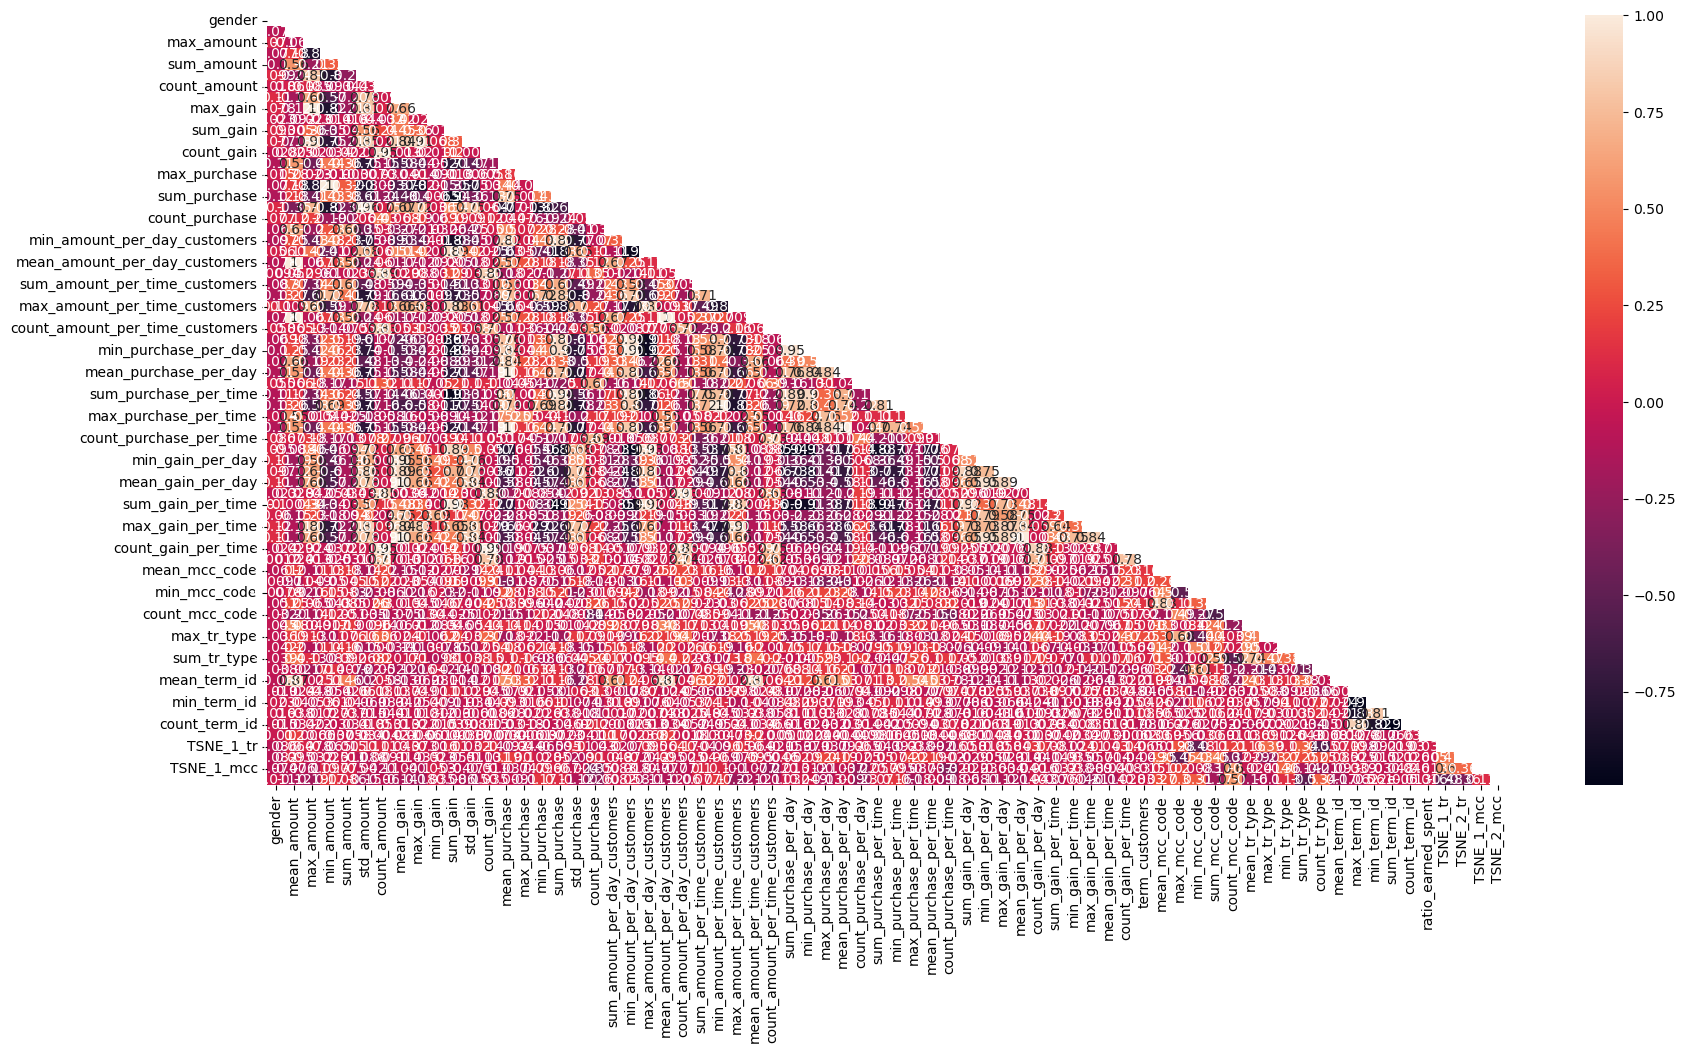

In [55]:
matrix = np.triu(gender.corr())
figure, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(gender.corr(), annot= True, ax= ax, mask= matrix);

In [25]:
transactions

,tr_datetime,mcc_code,tr_type,amount,term_id,gain,day,time,mean_amount,max_amount,...,max_amount_tr_type,min_amount_tr_type,sum_amount_tr_type,count_amount_tr_type,mean_amount_term_id,max_amount_term_id,min_amount_term_id,sum_amount_term_id,count_amount_term_id,ratio_earned_spent
customer_id,,,,,,,,,,,,,,,,,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,0,0,0,10,-13706.787839,224591.58,...,-22.46,-170689.60,-1.081702e+07,2329,-24697.688734,8983663.09,-22459157.72,-3.160563e+08,12797,0.200678
39026145,1 10:19:29,6011,7010,56147.89,0,1,1,10,-13706.787839,224591.58,...,5682166.90,449.18,8.567113e+07,318,-21350.908144,6737747.32,-6737747.32,-2.165623e+08,10143,0.200678
39026145,1 10:20:56,4829,2330,-56147.89,0,0,1,10,-13706.787839,224591.58,...,-67.38,-2605262.30,-2.278461e+07,118,-21350.908144,6737747.32,-6737747.32,-2.165623e+08,10143,0.200678
39026145,1 10:39:54,5499,1010,-1392.47,0,0,1,10,-13706.787839,224591.58,...,-17.29,-1512736.57,-4.801446e+07,2532,-21350.908144,6737747.32,-6737747.32,-2.165623e+08,10143,0.200678
39026145,2 15:33:42,5499,1010,-920.83,0,0,2,15,-13706.787839,224591.58,...,-22.46,-2417571.11,-4.553762e+07,2334,-26377.851514,6692829.00,-11229578.86,-2.333121e+08,8845,0.200678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61870738,453 16:03:02,5499,1010,-5176.84,10217113,0,453,16,-9423.614177,408756.67,...,-13.48,-2290834.09,-6.190685e+07,4275,-5176.840000,-5176.84,-5176.84,-5.176840e+03,1,0.154765
61870738,454 10:54:60,5411,1010,-1652.77,022915,0,454,10,-9423.614177,408756.67,...,-4.04,-1753386.44,-5.960029e+07,4121,-1652.770000,-1652.77,-1652.77,-1.652770e+03,1,0.154765
61870738,454 14:23:59,5499,1010,-4687.23,10217113,0,454,14,-9423.614177,408756.67,...,-4.04,-1753386.44,-5.960029e+07,4121,-4687.230000,-4687.23,-4687.23,-4.687230e+03,1,0.154765


In [26]:
transactions = transactions.join(gender)

In [27]:
df = pd.DataFrame(pd.get_dummies(data = transactions, columns = ['mcc_code', 'tr_type']))
df_customers = df.groupby(['customer_id']).mean()
df_customers = df_customers[df_customers['gender'].notna()]
Y = df_customers['gender']

In [28]:
df_customers

,amount,gain,day,time,mean_amount,max_amount,min_amount,sum_amount,std_amount,count_amount,...,tr_type_7040,tr_type_7041,tr_type_7044,tr_type_7070,tr_type_7071,tr_type_7074,tr_type_7075,tr_type_8100,tr_type_8145,tr_type_8146
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,-2691.438419,0.290598,238.568376,12.837607,-2691.438419,875907.15,-868607.92,-629796.59,127851.642622,234.0,...,0.000000,0.0,0.0,0.038462,0.012821,0.0,0.004274,0.0,0.0,0.0
27914,-26820.061441,0.315315,243.558559,11.486486,-26820.061441,89836.63,-462658.65,-2977026.82,104675.148673,111.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
28753,-90293.479116,0.170068,194.602041,6.503401,-90293.479116,3099363.77,-3244539.76,-26546282.86,785586.199773,294.0,...,0.003401,0.0,0.0,0.047619,0.000000,0.0,0.000000,0.0,0.0,0.0
31385,-5972.612548,0.063014,139.290411,14.550685,-5972.612548,199886.50,-364366.15,-2180003.58,33418.557369,365.0,...,0.000000,0.0,0.0,0.002740,0.000000,0.0,0.000000,0.0,0.0,0.0
38084,-2069.954916,0.119748,247.638655,12.093487,-2069.954916,1235253.67,-1142759.68,-1970597.08,138982.400359,952.0,...,0.000000,0.0,0.0,0.017857,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,-28573.389826,0.093023,249.540698,11.226744,-28573.389826,224591.58,-561478.94,-4914623.05,77960.256920,172.0,...,0.000000,0.0,0.0,0.005814,0.000000,0.0,0.000000,0.0,0.0,0.0
99967537,-142010.982308,0.000000,368.000000,11.923077,-142010.982308,-2245.92,-336887.37,-1846142.77,137243.506029,13.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
99988578,-13504.464201,0.129540,262.914044,14.894673,-13504.464201,673774.73,-808529.68,-11154687.43,80171.182955,826.0,...,0.000000,0.0,0.0,0.056901,0.059322,0.0,0.000000,0.0,0.0,0.0


In [29]:
df_customers = df_customers.drop(['gender'], axis= 1)

In [44]:
# gender['TSNE_1_tr'] = transactions.groupby('customer_id')['TSNE_1_tr'].mean()
# gender['TSNE_2_tr'] = transactions.groupby('customer_id')['TSNE_2_tr'].mean()
# gender['TSNE_1_mcc'] = transactions.groupby('customer_id')['TSNE_1_mcc'].mean()
# gender['TSNE_2_mcc'] = transactions.groupby('customer_id')['TSNE_2_mcc'].mean()

In [56]:
# x = gender[gender['gender'].notna()].fillna(0)
# y = x['gender']
# x = x.drop(['gender'], axis= 1)

In [69]:
# scaller = MinMaxScaler((0, 1))
norm = Normalizer()
# scaller = RobustScaler()
scaller = StandardScaler()
X_min_max = pd.DataFrame(scaller.fit_transform(x))
# X_min_max = pd.DataFrame(norm.fit_transform(scaller.fit_transform(x)))
# X_min_max = pd.DataFrame(scaller.fit_transform(df_lin))

# возвращаю названия колонкам 
for dq_c, df_c in zip(X_min_max.columns.to_list(), x.columns.to_list()):
    X_min_max.rename(columns = {dq_c : df_c}, inplace = True)

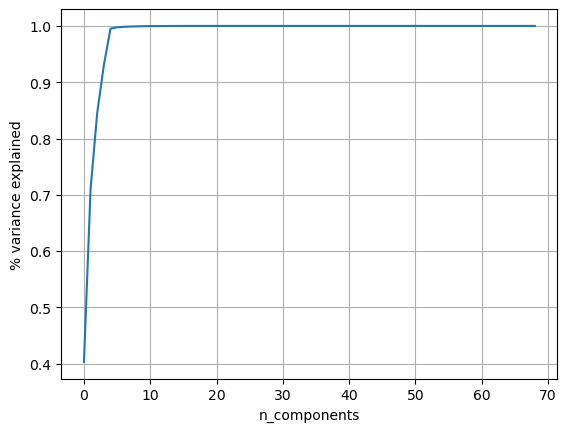

In [54]:
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [34]:
x_train, x_valid, y_train, y_valid = train_test_split(df_customers.fillna(0), Y, random_state= 900, test_size = 0.2)

In [35]:
from sklearn.feature_selection import RFE

In [39]:
rfe = RFE(estimator = GradientBoostingClassifier(learning_rate= 0.01), n_features_to_select= 100)

rfe.fit(x_train, y_train)
print(f"Train ROC-AUC score: {round(roc_auc_score(rfe.predict(x_train), y_train), 2)}.\nValid ROC-AUC score: {round(roc_auc_score(rfe.predict(x_valid), y_valid), 2)}.")

Train ROC-AUC score: 0.75.
Valid ROC-AUC score: 0.73.


In [58]:
# log_clf = LogisticRegression(random_state= 42)
# log_clf = RidgeClassifier()
# log_clf = SGDClassifier(max_iter= 10000, random_state= 42)
log_clf = SVC()
log_clf.fit(x_train, y_train)
print("Train roc-auc:", roc_auc_score(log_clf.predict(x_train), y_train))
print("Valid roc-auc:", roc_auc_score(log_clf.predict(x_valid), y_valid))

Train roc-auc: 0.6100963693411028
Valid roc-auc: 0.6164646464646465


In [37]:
# cat_clf = CatBoostClassifier(iterations= 400, depth= 2, model_size_reg= 3, learning_rate= 0.02, verbose= False)
cat_clf = CatBoostClassifier(learning_rate= 0.01, depth= 3, iterations= 300, verbose= False)
cat_clf.fit(x_train, y_train)

print("Train roc-auc:", roc_auc_score(cat_clf.predict(x_train), y_train))
print("Valid roc-auc:", roc_auc_score(cat_clf.predict(x_valid), y_valid))

Train roc-auc: 0.7709501576770684
Valid roc-auc: 0.772747078660253


In [52]:
cv_split = KFold(n_splits = 4)
cv_results = cross_validate(cat_clf, x, y, scoring= 'roc_auc', cv= cv_split, return_train_score= True)
cv_results['test_score'].mean()

0.6510931915808975

In [334]:
cat_clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 400,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 1,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 3,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 50,
 'loss_function': 'Logloss',
 'learning_rate': 0.0299999993

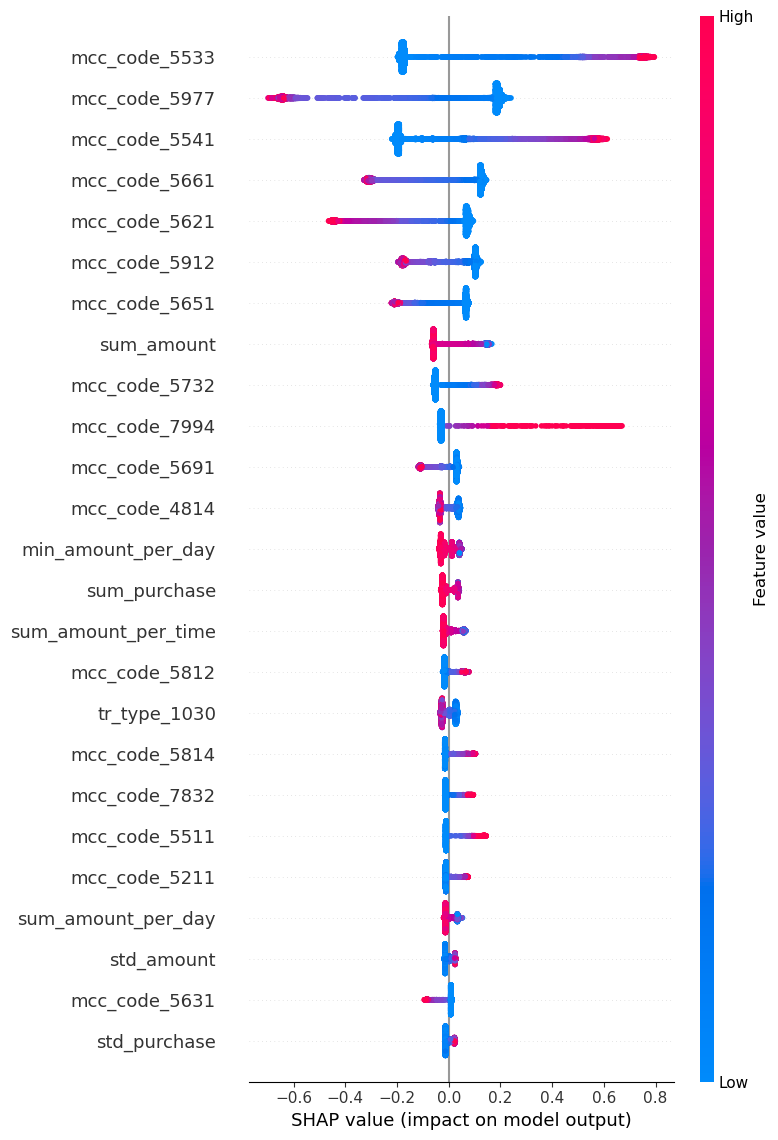

In [38]:
# отбор признаков SHAP
shap_test = shap.TreeExplainer(cat_clf).shap_values(x_train)
shap.summary_plot(shap_test, x_train,
                      max_display=25)

In [281]:
missing_features(X)

total_spent - 7 шт. (0.08 %)
total_earned - 686 шт. (8.17 %)


In [282]:
X = X.fillna(0)

### Нелинейный метод решения задачи

In [340]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state= 900, test_size = 0.2)

In [341]:
X_train

,amount,TSNE_1_tr,TSNE_2_tr,TSNE_1_mcc,TSNE_2_mcc,purchase,day,time,total,total_spent,total_earned,transactions_per_time,transactions_per_day,sum_per_day,avg_amount_per_day
customer_id,,,,,,,,,,,,,,,
81780909,336887.37,20.863789,37.893898,47.359173,42.293472,1,456,23,-4998958.04,-9776425.23,4777467.19,12.488994,225.911950,224591.58,224591.580
75669940,539019.79,26.490736,37.893898,47.359173,31.484732,1,456,23,-13226973.38,-23179749.12,9952775.74,14.854467,240.329971,514314.71,449183.150
6715387,9916.84,20.863789,37.893898,47.359173,29.232935,1,456,23,-3640500.11,-3650416.95,9916.84,13.556818,277.829545,-224.59,-224.590
85699963,-22.46,19.102261,37.893898,47.359173,31.484732,1,455,23,-6503052.90,-6503052.90,NaN,13.465306,237.730612,-224.59,-224.590
39813480,791685.31,20.863789,37.893898,47.359173,31.484732,1,455,23,-15810593.25,-18537135.02,2726541.77,13.126437,226.349425,791685.31,791685.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35032736,224591.58,26.490736,37.893898,47.359173,31.484732,1,455,23,-6892560.11,-7296824.95,404264.84,12.036810,232.730061,224591.58,224591.580
26348533,-449.18,22.482372,37.893898,47.359173,29.232935,1,455,18,-8576029.37,-8576029.37,NaN,10.583333,175.812500,-4491.83,-4491.830
5979147,5390197.85,26.490736,37.893898,47.359173,31.484732,1,450,23,-1209870.93,-24730223.87,23520352.94,12.747253,335.703297,6737747.31,1122957.885


In [355]:
cat_clf = CatBoostClassifier(iterations= 100, depth= 3, model_size_reg= 3, learning_rate= 0.01, verbose= False)
# cat_clf = CatBoostClassifier(verbose= False)
cat_clf.fit(X_train, Y_train)

print("Train roc-auc:", roc_auc_score(cat_clf.predict(X_train), Y_train))
print("Valid roc-auc:", roc_auc_score(cat_clf.predict(X_valid), Y_valid))

Train roc-auc: 0.626245661180159
Valid roc-auc: 0.6248061895710673


> ### Формула для расчета значения Шэпли для переменной:
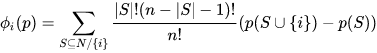

##### $p(S \cup \{ i \})$ — это предсказание модели с i-той фичей,

##### $p(S)$ — это предсказание модели без i-той фичи,

##### $n$ — количество фичей,

##### $S$ — произвольный набор фичей без i-той фичи

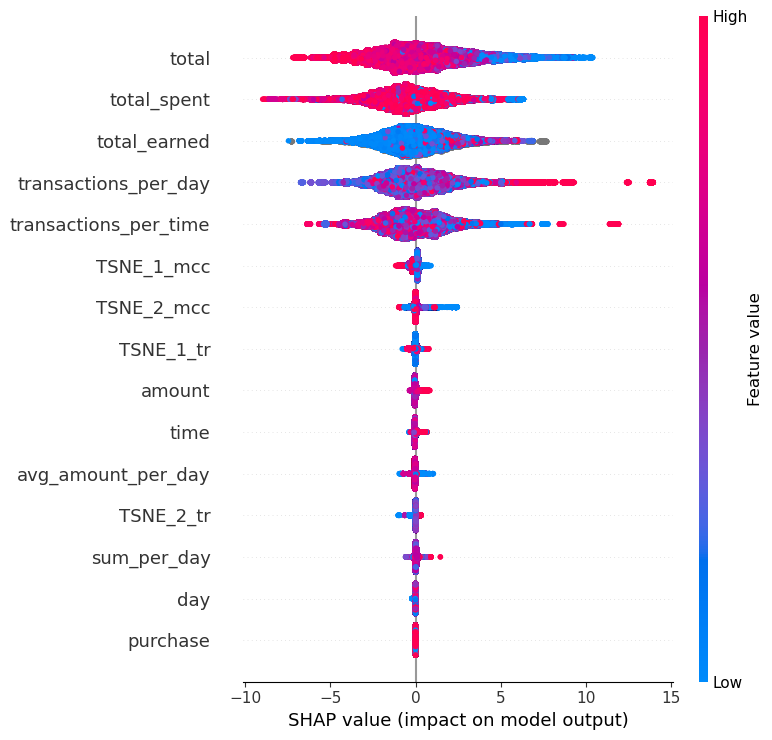

In [38]:
# отбор признаков SHAP
shap_test = shap.TreeExplainer(cat_clf).shap_values(X)
shap.summary_plot(shap_test, X,
                      max_display=25)

##### Интерпретация SHAP: 
* значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
* чем толще линия на графике, тем больше таких точек наблюдения
* чем краснее точки на графике, тем выше значения фичи в ней

In [42]:
kf = KFold(n_splits= 5, shuffle= True, random_state= 42)
valid_accuracy = []
for train_idx, valid_idx in kf.split(X, Y):
    
    cat_clf.fit(X.iloc[train_idx], Y.iloc[train_idx])
    valid_accuracy.append(roc_auc_score(Y.iloc[valid_idx], cat_clf.predict(X.iloc[valid_idx])))

print(f'Mean roc-auc score:{np.mean(valid_accuracy)}')

[0.9964158528371085, 0.9960085940754436, 0.9962378123932831, 0.9959335314434254, 0.9961023627990248]
Mean roc auc score:0.996139630709657


### Линейный метод решения задачи

In [65]:
df_customers

,amount,gender,TSNE_1_tr,TSNE_2_tr,TSNE_1_mcc,TSNE_2_mcc,purchase,day,time,total,total_spent,total_earned,transactions_per_time,transactions_per_day,sum_per_day,avg_amount_per_day
customer_id,,,,,,,,,,,,,,,,
6815,-5785.48,NaN,-23.735165,10.849582,19.966291,29.232935,1.0,241.0,12.0,-1249454.87,-3956007.97,2706553.10,12.699115,236.154867,-14482.120,-8848.908333
22899,-3368.87,1.0,-23.735165,4.052147,19.966291,28.981787,1.0,231.0,12.0,-629796.59,-6448719.64,5818923.05,12.837607,238.568376,-786.070,-374.320000
27914,-2245.92,1.0,14.007637,37.893898,47.359173,6.449200,1.0,256.0,11.0,-2977026.82,-3386906.52,409879.70,11.486486,243.558559,0.000,0.000000
28753,-14969.03,0.0,-31.872036,8.302735,19.966291,6.893485,1.0,150.0,7.0,-26546282.86,-72253691.83,45707408.97,6.503401,194.602041,-41170.110,-23368.757500
31385,-3009.53,0.0,-23.735165,10.849582,19.966291,29.232935,1.0,111.0,14.0,-2180003.58,-3431338.03,1251334.45,14.550685,139.290411,-13286.390,-5796.930000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99984336,-112295.79,NaN,-23.735165,-3.488037,19.966291,29.232935,1.0,250.0,9.0,-8196354.85,-10233400.45,2037045.60,9.857143,257.920635,-213362.000,-135877.905000
99985917,-224591.58,NaN,-23.735165,-3.488037,19.966291,29.232935,1.0,61.5,11.0,331115.38,-4924327.53,5255442.91,11.450000,110.800000,-1122957.880,-374319.293333
99988578,-4491.83,1.0,-23.735165,8.302735,19.966291,28.764906,1.0,284.0,16.0,-11154687.43,-18869408.19,7714720.76,14.894673,262.914044,-16085.135,-5342.994167


In [104]:
df_lin = df_customers[df_customers['gender'].notna()]
# df_lin = df_lin.drop(['tr_datetime', 'term_id', 'cleaned_tr_description', 'cleaned_mcc_description'], axis= 1)
df_lin = df_lin.fillna(0)
df_lin

,amount,gender,TSNE_1_tr,TSNE_2_tr,TSNE_1_mcc,TSNE_2_mcc,purchase,day,time,total,total_spent,total_earned,transactions_per_time,transactions_per_day,sum_per_day,avg_amount_per_day
customer_id,,,,,,,,,,,,,,,,
22899,-3368.870,1.0,-23.735165,4.052147,19.966291,28.981787,1.0,231.0,12.0,-629796.59,-6448719.64,5818923.05,12.837607,238.568376,-786.070,-374.320000
27914,-2245.920,1.0,14.007637,37.893898,47.359173,6.449200,1.0,256.0,11.0,-2977026.82,-3386906.52,409879.70,11.486486,243.558559,0.000,0.000000
28753,-14969.030,0.0,-31.872036,8.302735,19.966291,6.893485,1.0,150.0,7.0,-26546282.86,-72253691.83,45707408.97,6.503401,194.602041,-41170.110,-23368.757500
31385,-3009.530,0.0,-23.735165,10.849582,19.966291,29.232935,1.0,111.0,14.0,-2180003.58,-3431338.03,1251334.45,14.550685,139.290411,-13286.390,-5796.930000
38084,-6956.725,0.0,-25.069407,10.849582,19.966291,6.449200,1.0,246.0,13.0,-1970597.08,-28333044.22,26362447.14,12.093487,247.638655,-19090.280,-7385.558000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,-17027.075,0.0,-23.735165,-3.488037,19.966291,29.232935,1.0,251.0,11.0,-4914623.05,-6812421.89,1897798.84,11.226744,249.540698,-43750.445,-17143.823333
99967537,-145984.530,1.0,-23.735165,-3.488037,19.966291,29.232935,1.0,364.0,12.0,-1846142.77,-1846142.77,0.00,11.923077,368.000000,-274001.730,-131386.070000
99988578,-4491.830,1.0,-23.735165,8.302735,19.966291,28.764906,1.0,284.0,16.0,-11154687.43,-18869408.19,7714720.76,14.894673,262.914044,-16085.135,-5342.994167


In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
log_clf = LogisticRegression(random_state= 42)
# log_clf = RidgeClassifier()
# log_clf = SVC()
# log_clf = SGDClassifier(max_iter= 1000, random_state= 42)

In [113]:
# scaller = MinMaxScaler((1, 10))
norm = Normalizer()
# scaller = RobustScaler()
scaller = StandardScaler()
X_min_max = pd.DataFrame(norm.fit_transform(scaller.fit_transform(df_lin)))
# X_min_max = pd.DataFrame(scaller.fit_transform(df_lin))
# возвращаю названия колонкам 
for dq_c, df_c in zip(X_min_max.columns.to_list(), df_lin.columns.to_list()):
    X_min_max.rename(columns = {dq_c : df_c}, inplace = True)

In [114]:
X_min_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8400 entries, 0 to 8399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount                 8400 non-null   float64
 1   gender                 8400 non-null   float64
 2   TSNE_1_tr              8400 non-null   float64
 3   TSNE_2_tr              8400 non-null   float64
 4   TSNE_1_mcc             8400 non-null   float64
 5   TSNE_2_mcc             8400 non-null   float64
 6   purchase               8400 non-null   float64
 7   day                    8400 non-null   float64
 8   time                   8400 non-null   float64
 9   total                  8400 non-null   float64
 10  total_spent            8400 non-null   float64
 11  total_earned           8400 non-null   float64
 12  transactions_per_time  8400 non-null   float64
 13  transactions_per_day   8400 non-null   float64
 14  sum_per_day            8400 non-null   float64
 15  avg_

In [82]:
def get_VIF(dataFrame, target):
    X = add_constant(dataFrame.loc[:, dataFrame.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,)
    return seriesObject

target = 'gender'
print(get_VIF(X_min_max, target))

const                     1.000000
amount                    8.307154
TSNE_1_tr                 1.918549
TSNE_2_tr                 1.450463
TSNE_1_mcc                1.525407
TSNE_2_mcc                1.529216
purchase                  1.168966
day                       9.425596
time                      5.388373
total                          inf
total_spent                    inf
total_earned                   inf
transactions_per_time     5.502660
transactions_per_day      9.447893
sum_per_day               2.144332
avg_amount_per_day       10.997372
dtype: float64


divide by zero encountered in double_scalars


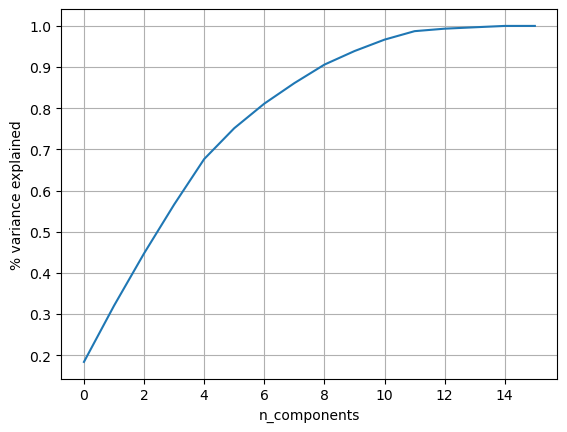

In [83]:
pca = PCA(n_components = X_min_max.shape[1])
pca_data = pca.fit_transform(X_min_max)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [359]:
cumm_var_explained

array([0.15079184, 0.27889867, 0.3942664 , 0.48872197, 0.56881393,
       0.64244222, 0.70930347, 0.76889764, 0.82038445, 0.86633234,
       0.90805593, 0.94515595, 0.96773095, 0.98831404, 1.        ,
       1.        ])

In [360]:
pca.explained_variance_

array([2.41267005e+00, 2.04970984e+00, 1.84588417e+00, 1.51128948e+00,
       1.28147174e+00, 1.17805296e+00, 1.06978029e+00, 9.53507009e-01,
       8.23789117e-01, 7.35166529e-01, 6.67577556e-01, 5.93600594e-01,
       3.61200001e-01, 3.29329496e-01, 1.86975461e-01, 3.64738591e-29])

In [361]:
sum(pca.explained_variance_ratio_)

1.0000000000000002

In [452]:
X_min_max = X_min_max.drop(['gender', 'total_spent'], axis= 1)

In [497]:
pca = PCA(n_components=12)
X_min_max = pd.DataFrame(pca.fit_transform(X_min_max))

In [348]:
# for dq_c, df_c in zip(pd.DataFrame(X_min_max.columns.to_list()), df_lin.columns.to_list()):
#     X_min_max.rename(columns = {dq_c : df_c}, inplace = True)

In [318]:
# X_min_max['amount_log'], X_min_max['total_log'], X_min_max['total_spent_log'], X_min_max['avg_amount_per_day_log'], X_min_max['sum_per_day_log'], X_min_max['total_earned_log'] = np.log(X_min_max['amount']), np.log(X_min_max['total']), np.log(X_min_max['total_spent']), np.log(X_min_max['avg_amount_per_day']), np.log(X_min_max['sum_per_day']), np.log(X_min_max['total_earned'])
# X_min_max = X_min_max.drop(['amount', 'total', 'total_spent', 'avg_amount_per_day', 'sum_per_day', 'total_earned'], axis= 1)


In [350]:
# fig, ax = plt.subplots(figsize = (15, 4))
# ax = sns.distplot(X_min_max['total'], hist=True, kde=True, 
#              bins= 100, color = 'green', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 1}).set(title='Total');
# plt.show()

In [351]:
# # корреляционная таблица для числовых переменных
# corr_matrix_int_float = X_min_max.corr(method='pearson')
# figure, ax = plt.subplots(figsize=(20, 10))
# sns.heatmap(corr_matrix_int_float, annot=True, ax=ax);

In [115]:
# X_min_max = X_min_max.drop(['TSNE_2_tr', 'TSNE_1_mcc', 'time', 'day', 'amount', 'total_spent', 'sum_per_day', 'purchase', 'gender'], axis= 1)
# X_min_max = X_min_max.drop(['amount', 'day', 'time', 'transactions_per_time', 'transactions_per_day', 'avg_amount_per_day', 'total', 'gender'], axis= 1)
X_min_max = X_min_max.drop(['gender'], axis= 1)

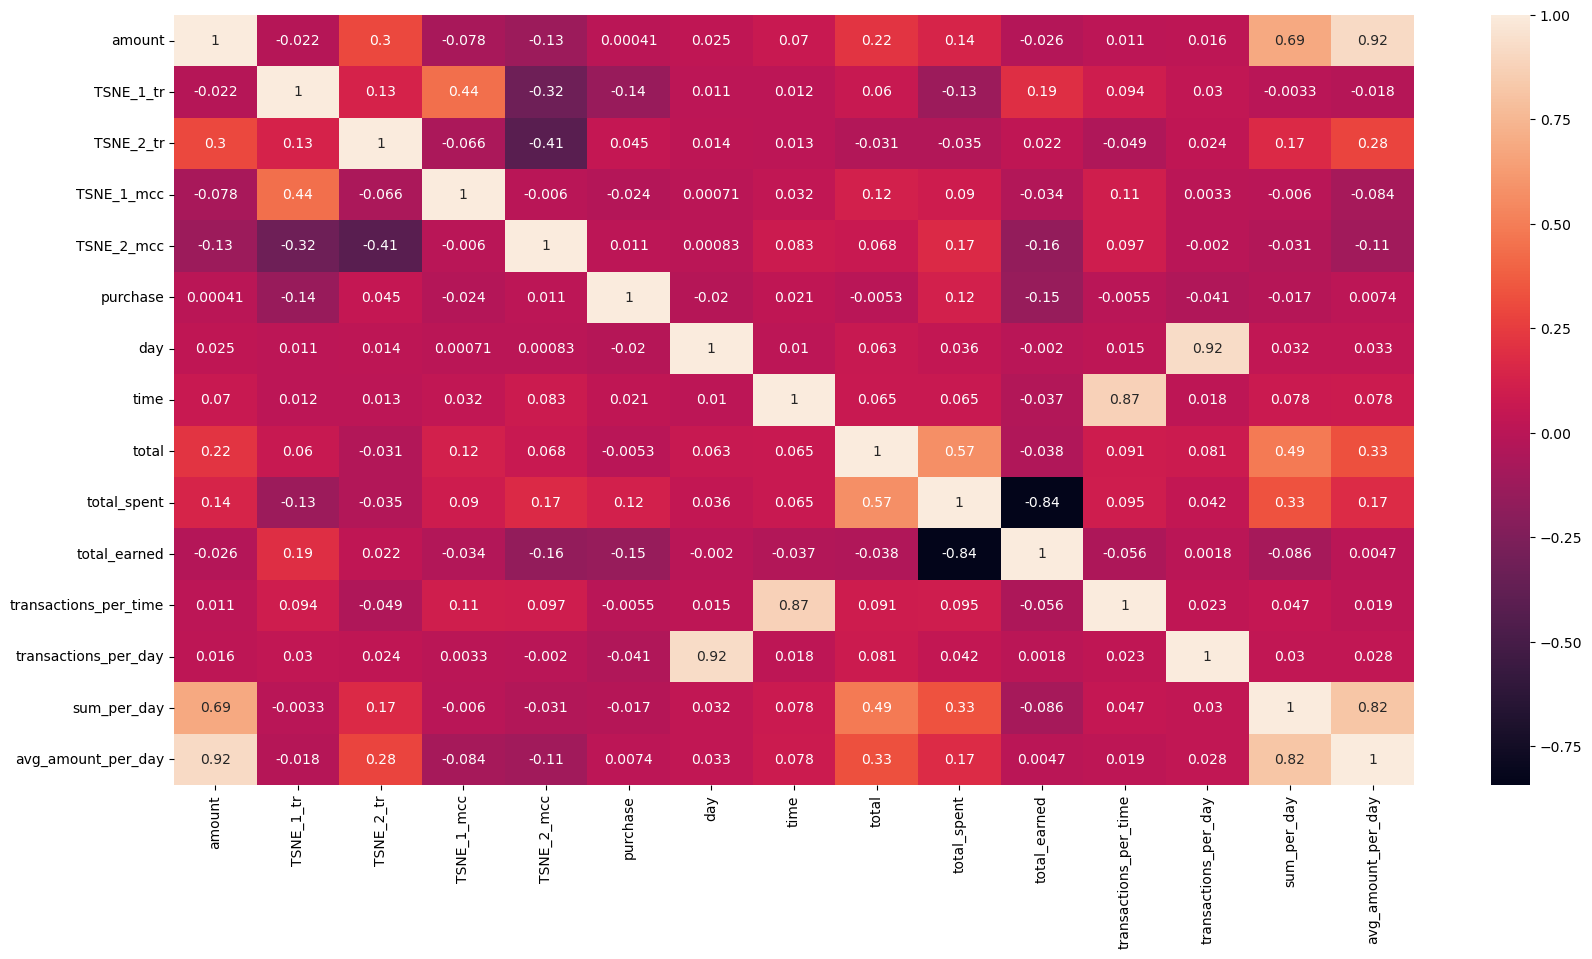

In [116]:
corr_matrix_int_float = X_min_max.corr(method='pearson')
figure, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix_int_float, annot=True, ax=ax);

In [103]:
X_min_max

,TSNE_1_tr,TSNE_2_tr,TSNE_1_mcc,TSNE_2_mcc,purchase,total_spent,total_earned,sum_per_day
0,-0.246879,-0.418621,0.449073,0.793326,0.126017,0.280108,-0.154026,0.189730
1,2.106566,3.270530,2.455725,-1.271309,0.126017,0.334714,-0.270896,0.193094
2,-0.754252,0.044744,0.449073,-1.230599,0.126017,-0.893501,0.707822,0.016899
3,-0.246879,0.322380,0.449073,0.816338,0.126017,0.333922,-0.252716,0.136233
4,-0.330076,0.322380,0.449073,-1.271309,0.126017,-0.110192,0.289846,0.111394
...,...,...,...,...,...,...,...,...
8395,-0.246879,-1.240590,0.449073,0.816338,0.126017,0.273621,-0.238748,0.005856
8396,-0.246879,-1.240590,0.449073,0.816338,0.126017,0.362193,-0.279753,-0.979548
8397,-0.246879,0.044744,0.449073,0.773453,0.126017,0.058589,-0.113065,0.124255
8398,-0.330076,-0.259381,0.449073,-0.490276,0.126017,0.105230,-0.033987,0.104377


In [65]:
Y

customer_id
22899       1.0
22899       1.0
22899       1.0
22899       1.0
22899       1.0
           ... 
69407297    0.0
69407297    0.0
69407297    0.0
69407297    0.0
79541861    0.0
Name: gender, Length: 3729289, dtype: float64

In [117]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_min_max, Y, random_state= 42, test_size= 0.2)

In [118]:
log_clf.fit(X_train, Y_train)
print("Train roc-auc score:", roc_auc_score(log_clf.predict(X_train), Y_train))
print("Valid roc-auc score:", roc_auc_score(log_clf.predict(X_valid), Y_valid))

Train roc-auc score: 0.6036529487599978
Valid roc-auc score: 0.5938772186940238


In [234]:
print(abs(X_min_max.corr()['gender']).sort_values(ascending=False)[1:4].index.to_list())

['total_log', 'TSNE_1_tr', 'transactions_per_time']
